# Tutorial 3: Training a spiking neural network on a simple vision dataset

Friedemann Zenke (https://fzenke.net)

> For more details on surrogate gradient learning, please see: 
> Neftci, E.O., Mostafa, H., and Zenke, F. (2019). Surrogate Gradient Learning in Spiking Neural Networks.
> https://arxiv.org/abs/1901.09948

In Tutorial 2, we have seen how to train a simple multi-layer spiking neural network on the [Fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist). However, the spiking activity in the hidden layer was not particularly plausible in a biological sense. Here we modify the network from this previous tutorial by adding activity regularizer, which encourages solutions with sparse spiking.

In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn
import torchvision


c:\Users\smuel\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# The coarse network structure is dicated by the Fashion MNIST dataset.
nb_inputs = 28*28
nb_hidden = 100
nb_outputs = 10

time_step = 1e-3
nb_steps = 100

batch_size = 256


In [4]:
dtype = torch.float

# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('Running on GPU.')
else:
    device = torch.device("cpu")
    print('Running on CPU.')


Running on GPU.


In [5]:
# Here we load the Dataset
root = os.path.expanduser("~/data/datasets/torch/fashion-mnist")
train_dataset = torchvision.datasets.FashionMNIST(
    root, train=True, transform=None, target_transform=None, download=True)
test_dataset = torchvision.datasets.FashionMNIST(
    root, train=False, transform=None, target_transform=None, download=True)


In [6]:
# Standardize data
# x_train = torch.tensor(train_dataset.train_data, device=device, dtype=dtype)
x_train = np.array(train_dataset.data, dtype=float)
x_train = x_train.reshape(x_train.shape[0], -1)/255
# x_test = torch.tensor(test_dataset.test_data, device=device, dtype=dtype)
x_test = np.array(test_dataset.data, dtype=float)
x_test = x_test.reshape(x_test.shape[0], -1)/255

# y_train = torch.tensor(train_dataset.train_labels, device=device, dtype=dtype)
# y_test  = torch.tensor(test_dataset.test_labels, device=device, dtype=dtype)
y_train = np.array(train_dataset.targets, dtype=int)
y_test = np.array(test_dataset.targets, dtype=int)


(-0.5, 27.5, 27.5, -0.5)

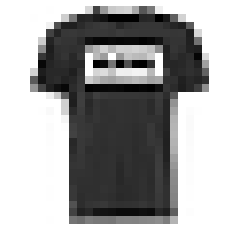

In [7]:
# Here we plot one of the raw data points as an example
data_id = 1
plt.imshow(x_train[data_id].reshape(28, 28), cmap=plt.cm.gray_r)
plt.axis("off")


Since we are working with spiking neural networks, we ideally want to use a temporal code to make use of spike timing. To that end, we will use a spike latency code to feed spikes to our network.

In [8]:
def current2firing_time(x, tau=20, thr=0.2, tmax=1.0, epsilon=1e-7):
    """ Computes first firing time latency for a current input x assuming the charge time of a current based LIF neuron.

    Args:
    x -- The "current" values

    Keyword args:
    tau -- The membrane time constant of the LIF neuron to be charged
    thr -- The firing threshold value 
    tmax -- The maximum time returned 
    epsilon -- A generic (small) epsilon > 0

    Returns:
    Time to first spike for each "current" x
    """
    idx = x < thr
    x = np.clip(x, thr+epsilon, 1e9)
    T = tau*np.log(x/(x-thr))
    T[idx] = tmax
    return T


def sparse_data_generator(X, y, batch_size, nb_steps, nb_units, shuffle=True):
    """ This generator takes datasets in analog format and generates spiking network input as sparse tensors. 

    Args:
        X: The data ( sample x event x 2 ) the last dim holds (time,neuron) tuples
        y: The labels
    """

    _, labels_ = np.unique(y, return_inverse=True)
    number_of_batches = len(X)//batch_size
    sample_index = np.arange(len(X))

    # compute discrete firing times
    tau_eff = 20e-3/time_step
    firing_times = np.array(current2firing_time(
        X, tau=tau_eff, tmax=nb_steps), dtype=int)
    unit_numbers = np.arange(nb_units)

    if shuffle:
        np.random.shuffle(sample_index)

    total_batch_count = 0
    counter = 0
    while counter < number_of_batches:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]

        coo = [[] for i in range(3)]
        for bc, idx in enumerate(batch_index):
            c = firing_times[idx] < nb_steps
            times, units = firing_times[idx][c], unit_numbers[c]

            batch = [bc for _ in range(len(times))]
            coo[0].extend(batch)
            coo[1].extend(times)
            coo[2].extend(units)

        i = torch.LongTensor(coo).to(device)
        v = torch.FloatTensor(np.ones(len(coo[0]))).to(device)

        X_batch = torch.sparse.FloatTensor(i, v, torch.Size(
            [batch_size, nb_steps, nb_units])).to(device)
        y_batch = torch.tensor(labels_[batch_index], device=device)

        yield X_batch.to(device=device), y_batch.to(device=device)

        counter += 1


### Setup of the spiking network model

In [9]:
tau_mem = 10e-3
tau_syn = 5e-3

alpha = float(np.exp(-time_step/tau_syn))
beta = float(np.exp(-time_step/tau_mem))


In [10]:
weight_scale = 0.2

w1 = torch.empty((nb_inputs, nb_hidden),  device=device,
                 dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

w2 = torch.empty((nb_hidden, nb_outputs), device=device,
                 dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

print("init done")


init done


In [11]:
def plot_voltage_traces(mem, spk=None, dim=(3, 5), spike_height=5):
    gs = GridSpec(*dim)
    if spk is not None:
        dat = 1.0*mem
        dat[spk > 0.0] = spike_height
        dat = dat.detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i == 0:
            a0 = ax = plt.subplot(gs[i])
        else:
            ax = plt.subplot(gs[i], sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")


## Training the network

In [12]:
class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements 
    the surrogate gradient. By subclassing torch.autograd.Function, 
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid 
    as this was done in Zenke & Ganguli (2018).
    """

    scale = 100.0  # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which 
        we need to later backpropagate our error signals. To achieve this we use the 
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the 
        surrogate gradient of the loss with respect to the input. 
        Here we use the normalized negative part of a fast sigmoid 
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad


# here we overwrite our naive spike function by the "SurrGradSpike" nonlinearity which implements a surrogate gradient
spike_fn = SurrGradSpike.apply


In [13]:
def run_snn(inputs):
    # Hidden layer
    h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    syn = torch.zeros((batch_size, nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size, nb_hidden), device=device, dtype=dtype)
    mem_rec = []
    spk_rec = []

    # Readout layer
    flt = torch.zeros((batch_size, nb_outputs), device=device, dtype=dtype)
    out_out = torch.zeros((batch_size, nb_outputs), device=device, dtype=dtype)
    out_rec = [out_out]

    # Compute network activity over time
    for t in range(nb_steps):
        # Hidden layer
        mthr = mem-1.0
        out = spike_fn(mthr)
        rst = out.detach()  # We do not want to backprop through the reset

        new_syn = alpha*syn + h1[:, t]
        new_mem = (beta*mem + syn)*(1.0-rst)

        mem_rec.append(mem)
        spk_rec.append(out)

        mem = new_mem
        syn = new_syn

        # Readout layer
        h2 = torch.einsum("ab,bc->ac", (out, w2))

        new_flt = alpha*flt + h2
        new_out = beta*out_out + flt

        flt = new_flt
        out_out = new_out

        out_rec.append(out_out)

    mem_rec = torch.stack(mem_rec, dim=1)
    spk_rec = torch.stack(spk_rec, dim=1)

    out_rec = torch.stack(out_rec, dim=1)
    other_recs = [mem_rec, spk_rec]
    return out_rec, other_recs


In [14]:
def train(x_data, y_data, lr=1e-3, nb_epochs=10):
    params = [w1, w2]
    optimizer = torch.optim.Adamax(params, lr=lr, betas=(0.9, 0.999))

    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()

    loss_hist = []
    for e in range(nb_epochs):
        local_loss = []
        for x_local, y_local in sparse_data_generator(x_data, y_data, batch_size, nb_steps, nb_inputs):
            output, recs = run_snn(x_local.to_dense())
            _, spks = recs
            m, _ = torch.max(output, 1)
            log_p_y = log_softmax_fn(m)

            # Here we set up our regularizer loss
            # The strength paramters here are merely a guess and there should be ample room for improvement by
            # tuning these paramters.
            # L1 loss on total number of spikes
            reg_loss = 1e-5*torch.sum(spks)
            # L2 loss on spikes per neuron
            reg_loss += 1e-5 * \
                torch.mean(torch.sum(torch.sum(spks, dim=0), dim=0)**2)

            # Here we combine supervised loss and the regularizer
            loss_val = loss_fn(log_p_y, y_local) + reg_loss

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            local_loss.append(loss_val.item())
        mean_loss = np.mean(local_loss)
        print("Epoch %i: loss=%.5f" % (e+1, mean_loss))
        loss_hist.append(mean_loss)

    return loss_hist


def compute_classification_accuracy(x_data, y_data):
    """ Computes classification accuracy on supplied data in batches. """
    accs = []
    for x_local, y_local in sparse_data_generator(x_data, y_data, batch_size, nb_steps, nb_inputs, shuffle=False):
        output, _ = run_snn(x_local.to_dense())
        m, _ = torch.max(output, 1)  # max over time
        _, am = torch.max(m, 1)      # argmax over output units
        # compare to labels
        tmp = np.mean((y_local == am).detach().cpu().numpy())
        accs.append(tmp)
    return np.mean(accs)


In [15]:
loss_hist = train(x_train, y_train, lr=2e-4, nb_epochs=200)


Epoch 1: loss=2.03115
Epoch 2: loss=1.56452
Epoch 3: loss=1.27515
Epoch 4: loss=1.07653
Epoch 5: loss=0.90417
Epoch 6: loss=0.81789
Epoch 7: loss=0.76027
Epoch 8: loss=0.71734
Epoch 9: loss=0.68629
Epoch 10: loss=0.66043
Epoch 11: loss=0.63861
Epoch 12: loss=0.62155
Epoch 13: loss=0.60661
Epoch 14: loss=0.59345
Epoch 15: loss=0.58150
Epoch 16: loss=0.57131
Epoch 17: loss=0.56241
Epoch 18: loss=0.55242
Epoch 19: loss=0.54606
Epoch 20: loss=0.53948
Epoch 21: loss=0.53139
Epoch 22: loss=0.52553
Epoch 23: loss=0.52015
Epoch 24: loss=0.51436
Epoch 25: loss=0.51014
Epoch 26: loss=0.50595
Epoch 27: loss=0.50211
Epoch 28: loss=0.49635
Epoch 29: loss=0.49295
Epoch 30: loss=0.48741
Epoch 31: loss=0.48393
Epoch 32: loss=0.47981
Epoch 33: loss=0.47735
Epoch 34: loss=0.47256
Epoch 35: loss=0.47012
Epoch 36: loss=0.46647
Epoch 37: loss=0.46249
Epoch 38: loss=0.46080
Epoch 39: loss=0.45701
Epoch 40: loss=0.45453
Epoch 41: loss=0.45037
Epoch 42: loss=0.44866
Epoch 43: loss=0.44624
Epoch 44: loss=0.444

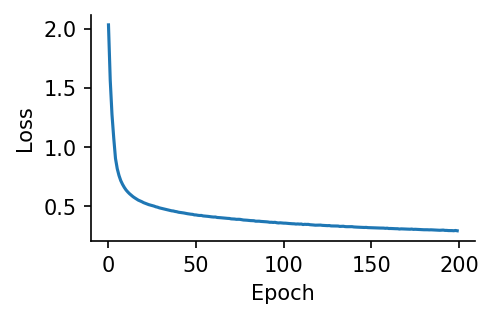

In [16]:
plt.figure(figsize=(3.3, 2), dpi=150)
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()


In [17]:
print("Training accuracy: %.3f" %
      (compute_classification_accuracy(x_train, y_train)))
print("Test accuracy: %.3f" %
      (compute_classification_accuracy(x_test, y_test)))


Training accuracy: 0.912
Test accuracy: 0.842


In [18]:
def get_mini_batch(x_data, y_data, shuffle=False):
    for ret in sparse_data_generator(x_data, y_data, batch_size, nb_steps, nb_inputs, shuffle=shuffle):
        return ret


In [19]:
x_batch, y_batch = get_mini_batch(x_test, y_test)
output, other_recordings = run_snn(x_batch.to_dense())
mem_rec, spk_rec = other_recordings


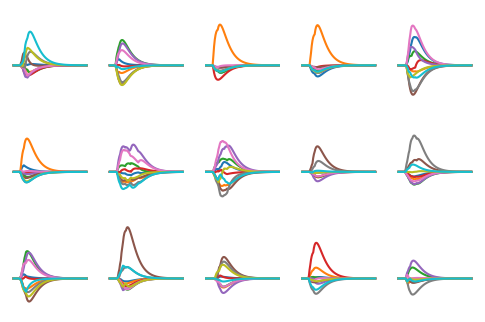

In [20]:
fig = plt.figure(dpi=100)
plot_voltage_traces(output)


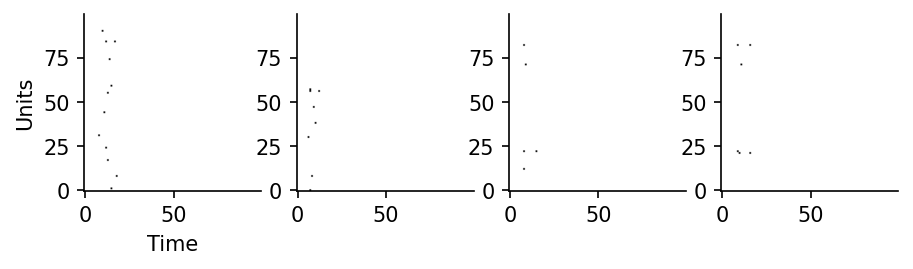

In [21]:
# Let's plot the hiddden layer spiking activity for some input stimuli

nb_plt = 4
gs = GridSpec(1, nb_plt)
fig = plt.figure(figsize=(7, 3), dpi=150)
for i in range(nb_plt):
    plt.subplot(gs[i])
    plt.imshow(spk_rec[i].detach().cpu().numpy().T,
               cmap=plt.cm.gray_r, origin="lower")
    if i == 0:
        plt.xlabel("Time")
        plt.ylabel("Units")

    sns.despine()


Compared to the hidden layer activity in our previous Tutorial 2, we can now appreciate that spiking in the hidden layer is much sparser.

In the next tutorial notebook, we will apply the same training paradigm to the Heidelberg Digits, a realistic speech dataset generated from spoken digits processed through a plausible cochlea model.

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.